Load Julia packages (libraries) needed  for the snippets in chapter 0

In [1]:
using StatisticalRethinking
using CmdStan, StanMCMCChain
gr(size=(500,500));

CmdStan uses a tmp directory to store the output of cmdstan

In [2]:
ProjDir = rel_path("..", "scripts", "05")
cd(ProjDir)

### snippet 5.1

In [3]:
wd = CSV.read(rel_path("..", "data", "WaffleDivorce.csv"), delim=';')
df = convert(DataFrame, wd);
mean_ma = mean(df[:MedianAgeMarriage])
df[:MedianAgeMarriage] = convert(Vector{Float64},
  df[:MedianAgeMarriage]) .- mean_ma;
first(df, 5)

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
,String⍰,String⍰,Float64⍰,Float64,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Float64⍰
1,Alabama,AL,4.78,-0.754,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
2,Alaska,AK,0.71,-0.854,26.0,2.93,12.5,2.05,0,0,0,0,0.0
3,Arizona,AZ,6.33,-0.254,20.3,0.98,10.8,0.74,18,0,0,0,0.0
4,Arkansas,AR,2.92,-1.754,26.4,1.7,13.5,1.22,41,1,111115,435450,0.26
5,California,CA,37.25,0.746,19.1,0.39,8.0,0.24,0,0,0,379994,0.0


Define the Stan language model

In [4]:
ad_model = "
data {
 int < lower = 1 > N; // Sample size
 vector[N] divorce; // Predictor
 vector[N] median_age; // Outcome
}

parameters {
 real a; // Intercept
 real bA; // Slope (regression coefficients)
 real < lower = 0 > sigma; // Error SD
}

model {
  # priors
  a ~ normal(10, 10);
  bA ~ normal(0, 1);
  sigma ~ uniform(0, 10);
  # model
  divorce ~ normal(a + bA*median_age , sigma);
}
";

Define the Stanmodel and set the output format to :mcmcchain.

In [5]:
stanmodel = Stanmodel(name="MedianAgeDivorce", monitors = ["a", "bA", "sigma"],
  model=ad_model, output_format=:mcmcchain);
# Input data for cmdstan
maddata = Dict("N" => length(df[:Divorce]), "divorce" => df[:Divorce],
    "median_age" => df[:MedianAgeMarriage]);
# Sample using cmdstan
rc, chn, cnames = stan(stanmodel, maddata, ProjDir, diagnostics=false,
  summary=false, CmdStanDir=CMDSTAN_HOME);
# Describe the draws
describe(chn)


File /Users/rob/.julia/dev/StatisticalRethinking/scripts/05/tmp/MedianAgeDivorce.stan will be updated.

Iterations = 1:1000
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 1000

Empirical Posterior Estimates:
         Mean        SD       Naive SE       MCSE      ESS
    a  9.6787068 0.21398592 0.0033834145 0.0035740238 1000
   bA -0.8479134 0.17438717 0.0027573033 0.0029814984 1000
sigma  1.5161364 0.16117452 0.0025483929 0.0029356600 1000

Quantiles:
         2.5%       25.0%     50.0%      75.0%      97.5%  
    a  9.2625985  9.5369400  9.679290  9.8184800 10.1042150
   bA -1.1913807 -0.9620685 -0.849530 -0.7327685 -0.5038570
sigma  1.2385647  1.4041025  1.503035  1.6105625  1.8727103



Plot the density of posterior draws

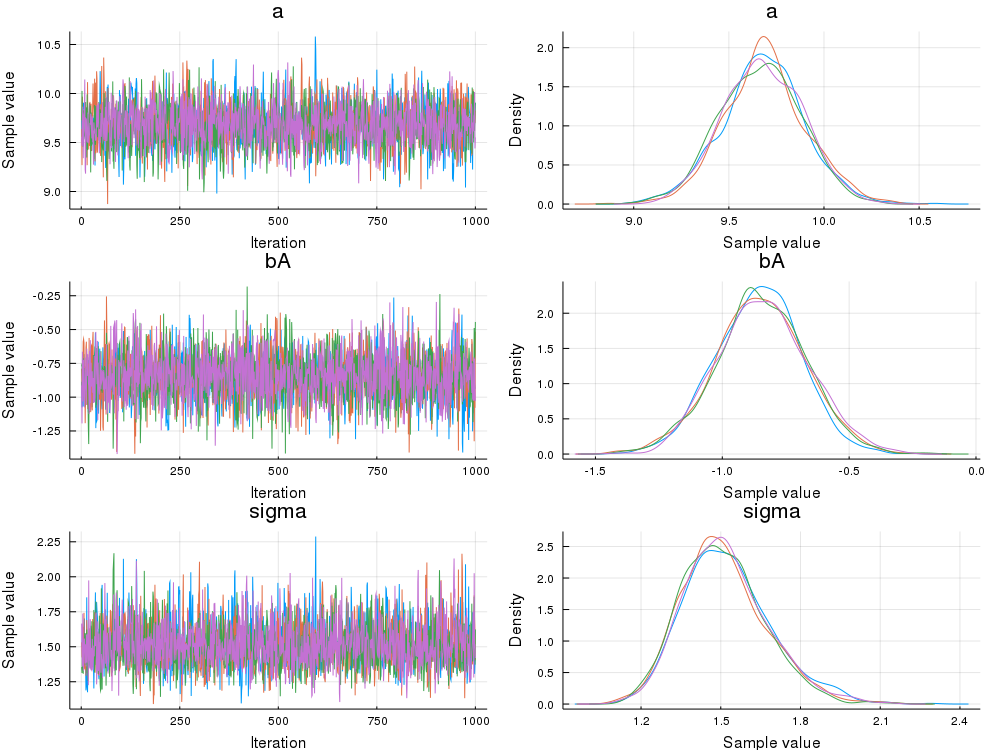

In [6]:
plot(chn)

Plot regression line using means and observations

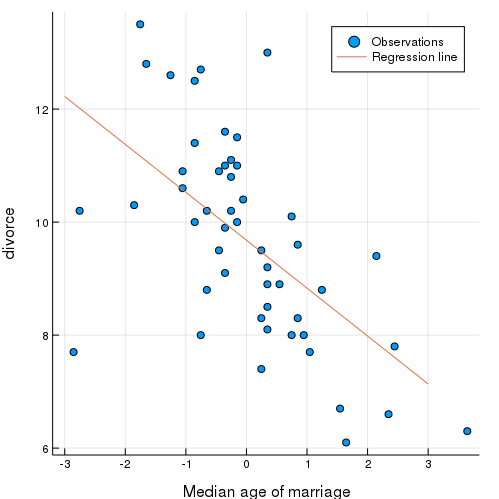

In [7]:
xi = -3.0:0.1:3.0
rws, vars, chns = size(chn[:, 1, :])
alpha_vals = convert(Vector{Float64}, reshape(chn.value[:, 1, :], (rws*chns)))
beta_vals = convert(Vector{Float64}, reshape(chn.value[:, 2, :], (rws*chns)))
yi = mean(alpha_vals) .+ mean(beta_vals)*xi

scatter(df[:MedianAgeMarriage], df[:Divorce], lab="Observations",
  xlab="Median age of marriage", ylab="divorce")
plot!(xi, yi, lab="Regression line")

Plot estimates using the N = [10, 50, 150, 352] observations

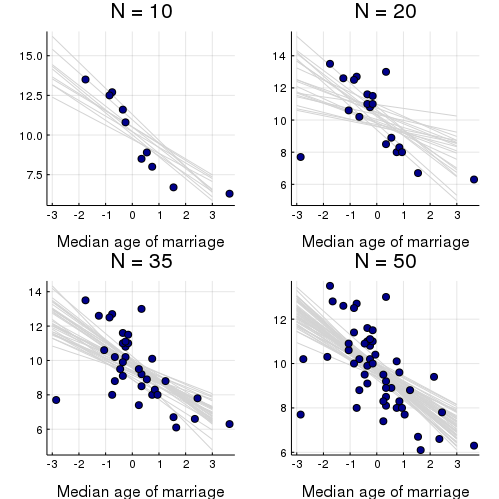

In [8]:
p = Vector{Plots.Plot{Plots.GRBackend}}(undef, 4)
nvals = [10, 20, 35, 50]

for i in 1:length(nvals)
  N = nvals[i]
  maddataN = Dict("N" => N, "divorce" => df[1:N, :Divorce],
      "median_age" => df[1:N, :MedianAgeMarriage]);
  rc, chnN, cnames = stan(stanmodel, maddataN, ProjDir, diagnostics=false,
    summary=false, CmdStanDir=CMDSTAN_HOME)

  xi = -3.0:0.1:3.0
  rws, vars, chns = size(chnN[:, 1, :])
  alpha_vals = convert(Vector{Float64}, reshape(chnN.value[:, 1, :], (rws*chns)))
  beta_vals = convert(Vector{Float64}, reshape(chnN.value[:, 2, :], (rws*chns)))

  p[i] = plot()
  for j in 1:N
    yi = alpha_vals[j] .+ beta_vals[j]*xi
    plot!(p[i], xi, yi, title="N = $N", color=:lightgrey)
  end
  p[i] = scatter!(p[i], df[1:N, :MedianAgeMarriage], df[1:N, :Divorce],
    leg=false, color=:darkblue, xlab="Median age of marriage")
end
plot(p..., layout=(2, 2))

End of `05/clip_01s.jl`

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*